In [15]:
from typing import (
    List,
    Tuple,
)

import pandas as pd 
import numpy as np
import ast

import colorsys
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.ticker as ticker


def change_saturation(
    rgb: Tuple[float, float, float],
    saturation: float = 0.6,
) -> Tuple[float, float, float]:
    """
    Changes the saturation of a color by a given amount. 
    Args:
        rgb (tuple): rgb color
        saturation (float, optional): saturation chante. 
    """
    hsv = colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])
    saturation = max(0, min(hsv[1] * saturation, 1))
    return colorsys.hsv_to_rgb(hsv[0], saturation, hsv[2])


def get_palette(
    n: int = 3,
    palette_name: str = 'colorblind',
    saturation: float = 0.6,
) -> List[Tuple[float, float, float]]:
    """
    Get color palette
    Args:
        n (int, optional): number of colors. 
        palette (str, optional): color palette. Defaults to 'colorblind'.
        saturation (float, optional): saturation of the colors. Defaults to 0.6.
    """
    palette = sns.color_palette(palette_name, n)
    return [change_saturation(color, saturation) for color in palette]

def lighten_color(
    color, 
    amount=0.5, 
    desaturation=0.2,
) -> Tuple[float, float, float]:
    """
    Copy-pasted from Eric's slack.
    Lightens and desaturates the given color by multiplying (1-luminosity) by the given amount
    and decreasing the saturation by the specified desaturation amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    Examples:
    >> lighten_color('g', 0.3, 0.2)
    >> lighten_color('#F034A3', 0.6, 0.4)
    >> lighten_color((.3,.55,.1), 0.5, 0.1)
    """
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    h, l, s = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(h, 1 - amount * (1 - l), max(0, s - desaturation))

def get_fancy_bbox(
    bb, 
    boxstyle, 
    color, 
    background=False, 
    mutation_aspect=3,
) -> FancyBboxPatch:
    """
    Copy-pasted from Eric's slack.
    Creates a fancy bounding box for the bar plots.
    """
    if background:
        height = bb.height - 2
    else:
        height = bb.height
    if background:
        base = bb.ymin # - 0.2
    else:
        base = bb.ymin
    return FancyBboxPatch(
        (bb.xmin, base),
        abs(bb.width), height,
        boxstyle=boxstyle,
        ec="none", fc=color,
        mutation_aspect=mutation_aspect, # change depending on ylim
        zorder=2)


def plot_results(
    n_runs: int, 
    directory: str,
    data: list,
    linewidth: int = 5,
    zorder: int = 1,
    scatter_color: str = '#000000',
    font_family: str = 'Avenir',
    font_size: int = 34,
    y_label_coords: tuple = (-0.07, 0.5),
    y_ticks: list = [0, 0.2, 0.4, 0.6, 0.8, 1],
    y_ticklabels: list = [0, 20, 40, 60, 80, 100],
    y_lim: tuple = (-0.05, 1.05),
    legend: bool = True,
    legend_title: str = 'Agent',
    legend_loc: str = 'center left',
    bbox_to_anchor: tuple = (1.0, 0.6),
    xlabel='Epoch',
    ylabel='Offered Share (%)',
    group_labels: list = ['altruistic', 'fair', 'selfish'],
    
                      ):

    # Palette and labels for different groups
    palette_line = get_palette(n=5, saturation=0.6)
    palette_error = get_palette(n=5, saturation=0.6)
    line_styles = ['solid', 'solid', 'solid']
    markers = ['X', 'p', 'H']

    scatter_color = lighten_color(scatter_color, 0.5, 0.5)

    

    
    x = [f"{i+1}" for i in range(n_runs)]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    # plot the fixed
    for i, agent_data in enumerate(data):
        if i == 0:
            for j in range(len(agent_data["Data"])):
                line = ax.plot(x, agent_data["Data"][j], label="Fixed", color=palette_line[1], linestyle=line_styles[j], linewidth=linewidth, zorder=zorder)
                ax.fill_between(x, [y_val - err if y_val is not np.nan else 0 for y_val, err in zip(agent_data["Data"][j], agent_data["Error"][j])],
                                [y_val + err if y_val is not np.nan else 0 for y_val, err in zip(agent_data["Data"][j], agent_data["Error"][j])],
                    color=palette_error[1], alpha=0.3)
                ax.scatter(x, agent_data["Data"][j], color=[scatter_color] * len(x), marker=markers[j], s=300)
               
        else:
            for j in range(len(agent_data["Data"])):
                line = ax.plot(x, agent_data["Data"][j], label="Flex", color=palette_line[0], linestyle=line_styles[j], linewidth=linewidth, zorder=zorder)
                ax.fill_between(x, [y_val - err if y_val is not np.nan else 0 for y_val, err in zip(agent_data["Data"][j], agent_data["Error"][j])],
                                [y_val + err if y_val is not np.nan else 0 for y_val, err in zip(agent_data["Data"][j], agent_data["Error"][j])],
                    color=palette_error[0], alpha=0.3)
                ax.scatter(x, agent_data["Data"][j], color=[scatter_color] * len(x), marker=markers[j], s=300)


    sns.despine(left=True, bottom=False)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, fontsize=30)


    ax.set_ylabel(ylabel, family=font_family, size=font_size)
    # ax.yaxis.set_label_coords(*y_label_coords)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels, size=30)
    ax.set_xlabel(xlabel, family=font_family, size=font_size)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5, zorder=-100)
    plt.ylim(y_lim)
    plt.tight_layout()


    fig.savefig(f'{directory}.pdf', format='pdf')
    fig.savefig(f'{directory}.png', format='png')
    plt.show()


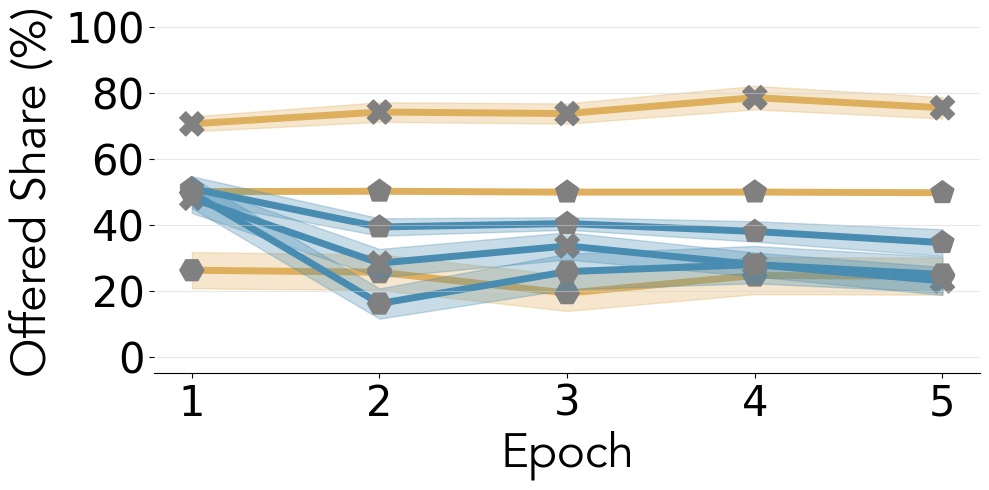

In [24]:
data_path_fixed = 'one_group_norm/final_graphs_and_data_1v9/all_fixed_data.csv'
data_path_flex = 'one_group_norm/final_graphs_and_data_1v9/all_flex_data.csv'

# load csvs
fixed_data = pd.read_csv(data_path_fixed)
flex_data = pd.read_csv(data_path_flex)

def str_to_np_array(s):
    # Convert string to list of floats
    if isinstance(s, str) and s[0] == '[' and s[-1] == ']':
        s = s[1:-1]  # Remove brackets
        s = s.split()  # Split by space
        s = [float(x) for x in s]  # Convert to list of floats
        return np.array(s)  # Convert list to NumPy array
    return s

# Sample data paths
data_path_fixed = 'sociopath/final_graphs_and_data/all_fixed_data.csv'
data_path_flex = 'sociopath/final_graphs_and_data/all_flex_data.csv'


# Load CSVs into pandas DataFrames
fixed_data = pd.read_csv(data_path_fixed)
flex_data = pd.read_csv(data_path_flex)

# Apply str_to_np_array to each cell
fixed_data = fixed_data.applymap(str_to_np_array)
flex_data = flex_data.applymap(str_to_np_array)

data = [fixed_data, flex_data]
fixed_data["Data"][0], fixed_data["Error"][0]

plot_results(n_runs=5, directory="sociopath", data=data)